In [1]:
from pathlib import Path
import os
cwd_path = Path.cwd(); set_path = str(cwd_path.parent.parent); os.chdir(set_path)

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
%reload_ext autoreload

In [6]:
from FittedModels.Models.FlowModel import FlowModel
from FittedModels.AIS_train.train_AIS import AIS_trainer
from ImportanceSampling.VanillaImportanceSampler import VanillaImportanceSampling
from FittedModels.utils.plotting_utils import plot_history, plot_distributions, plot_samples
import matplotlib.pyplot as plt
import torch
from TargetDistributions.MoG import MoG
from Utils.plotting_utils import plot_func2D, plot_distribution
from Utils.numerical_utils import MC_estimate_true_expectation
from Utils.numerical_utils import quadratic_function as expectation_function
torch.set_default_dtype(torch.float64)

# Specifiy target distribution and key param

## MoG

In [7]:
torch.manual_seed(2)
epochs = 500
dim = 6
n_samples_estimation = int(1e4)
target = MoG(dim=dim, n_mixes=10, min_cov=1, loc_scaling=5)
true_expectation = MC_estimate_true_expectation(target, expectation_function, int(1e6))
print(true_expectation)
if dim == 2:
    fig = plot_distribution(target, bounds=[[-30, 20], [-20, 20]])

tensor(51.6871)


# Setup AIS training

In [8]:
learnt_sampler = FlowModel(x_dim=dim, scaling_factor=5.0, flow_type="RealNVP", n_flow_steps=60)
tester = AIS_trainer(target, learnt_sampler, loss_type="kl", n_distributions=20, n_updates_Metropolis=3,
                    noise_scaling=1.0)

### Visualisation before training
Let's look at the effective sample size before training of vanilla IS vs annealed IS

In [9]:
n_samples_expectation = int(1e6)
n_samples=int(1e3)

In [10]:
vanilla_IS = VanillaImportanceSampling(sampling_distribution=learnt_sampler, target_distribution=target)
with torch.no_grad():
    expectation_vanilla, info_dict_vanilla = \
    vanilla_IS.calculate_expectation(n_samples_expectation, expectation_function=expectation_function)
print(f"true expectation is {true_expectation}, estimated expectation is {expectation_vanilla}")
print(f"ESS is {info_dict_vanilla['effective_sample_size']/n_samples_expectation}, \
      var is {torch.var(info_dict_vanilla['normalised_sampling_weights'])}")

true expectation is 51.68707930845954, estimated expectation is 52.05955407764828
ESS is 0.0001444301985767153,       var is 6.922766710287697e-09


true expectation is 51.68707930845954, estimated expectation is 52.39300383301115
ESS is 0.002523545985704827, var is 3.9526818903152094e-10


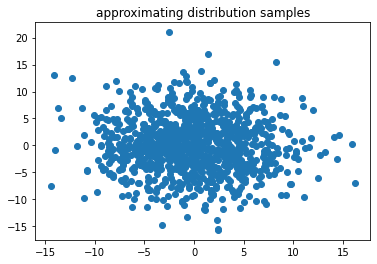

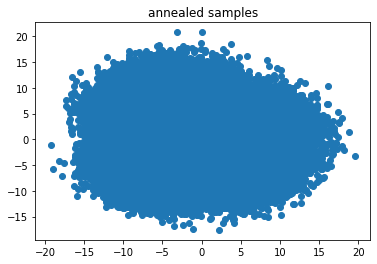

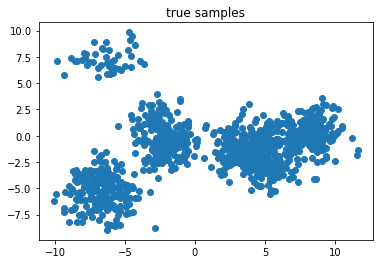

In [11]:
with torch.no_grad():
    expectation, info_dict = tester.AIS_train.calculate_expectation(n_samples_expectation,
                                                                    expectation_function=expectation_function)
print(f"true expectation is {true_expectation}, estimated expectation is {expectation}")
print(
    f"ESS is {info_dict['effective_sample_size'] / n_samples_expectation}, "
    f"var is {torch.var(info_dict['normalised_sampling_weights'])}")

plt.figure()
learnt_dist_samples = learnt_sampler.sample((n_samples,)).cpu().detach()
plt.scatter(learnt_dist_samples[:, 0], learnt_dist_samples[:, 1])
plt.title("approximating distribution samples")
plt.show()
plt.figure()
plt.scatter(info_dict["samples"][:, 0].cpu(), info_dict["samples"][:, 1].cpu())
plt.title("annealed samples")
plt.show()
plt.figure()
true_samples = target.sample((n_samples,)).cpu().detach()
plt.scatter(true_samples[:, 0], true_samples[:, 1])
plt.title("true samples")
plt.show()

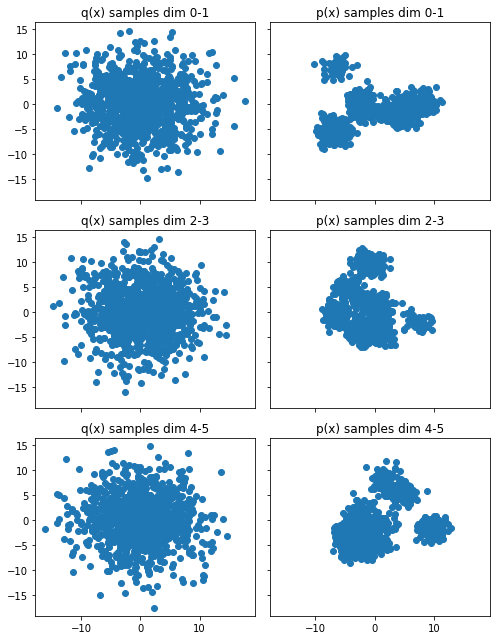

In [12]:
plot_samples(tester)

# Now let's train

loss: 2.9395088886925302, mean log p_x -12.753216447632175:  40%|████      | 20/50 [03:54<05:45, 11.53s/it]/home/loll/ToyProblems/FittedModels/utils/plotting_utils.py:149: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axs = plt.subplots(rows, 2, sharex="all", sharey="all", figsize=(7, 3 * rows))
loss: 3.304867644032887, mean log p_x -12.232016119709911:  62%|██████▏   | 31/50 [05:50<03:35, 11.32s/it] 


ValueError: The value argument must be within the support

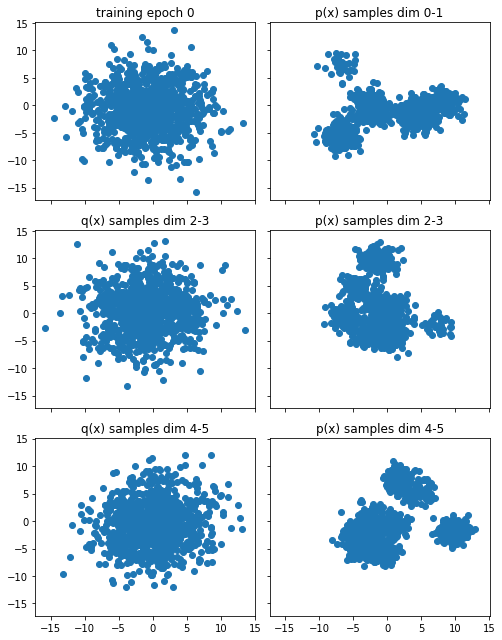

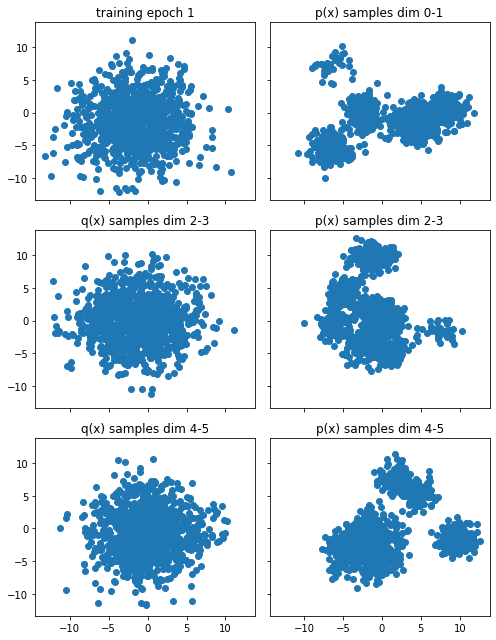

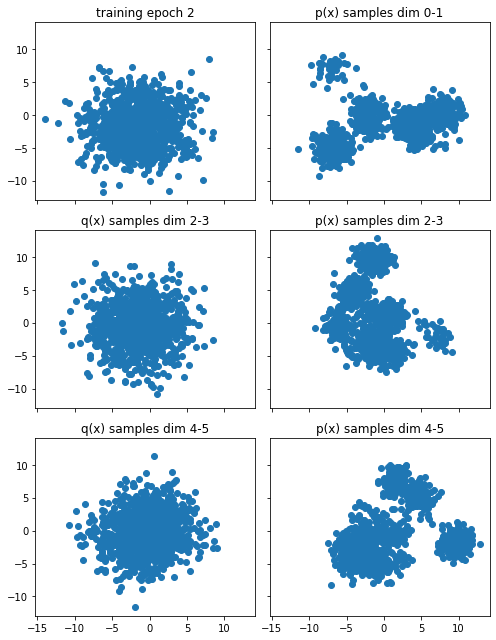

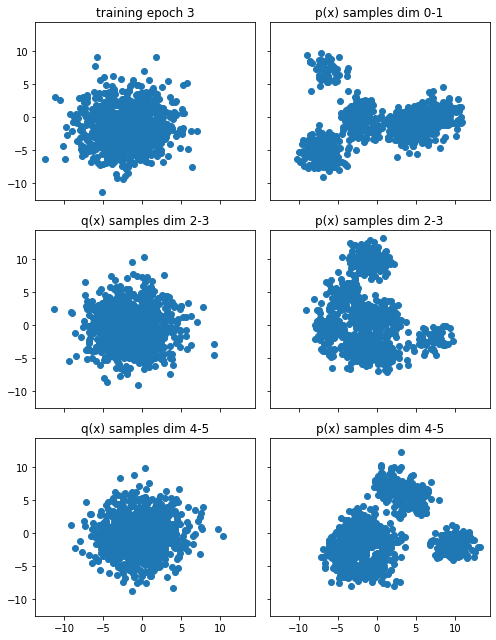

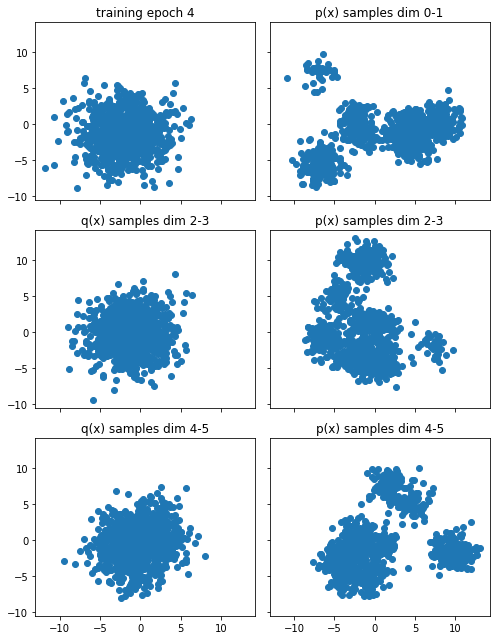

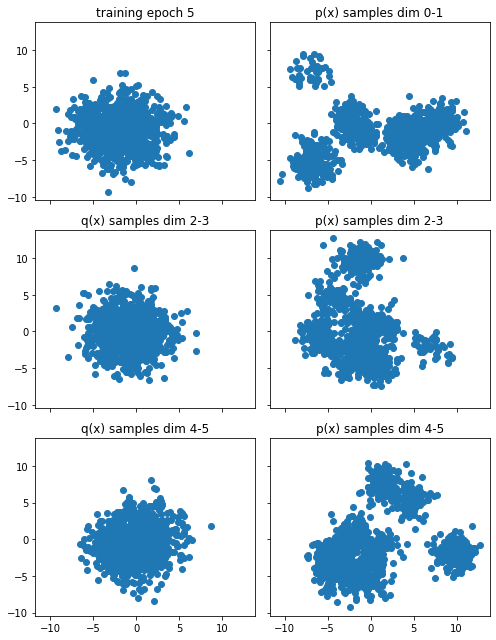

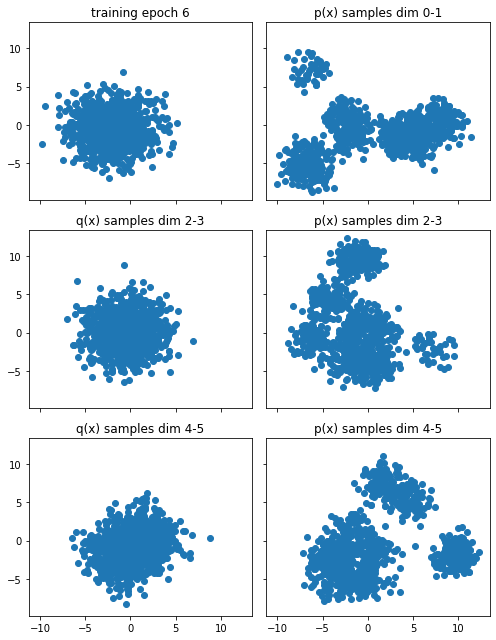

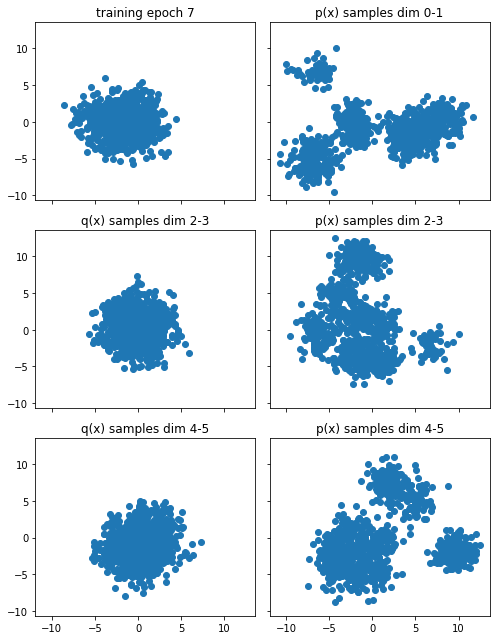

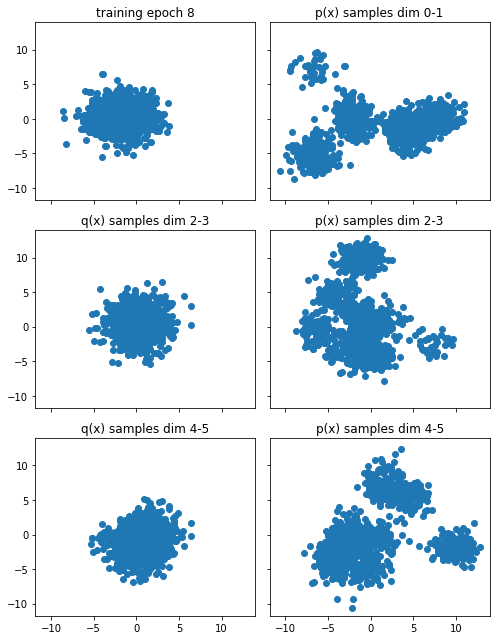

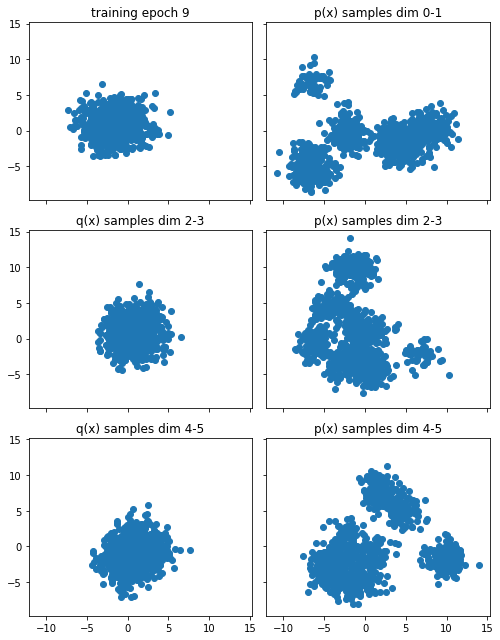

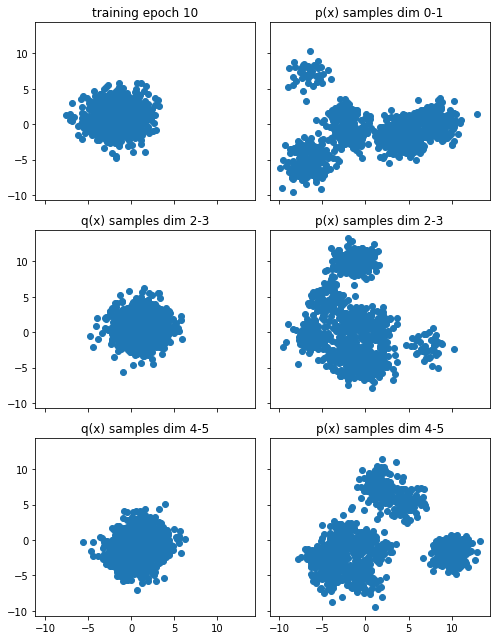

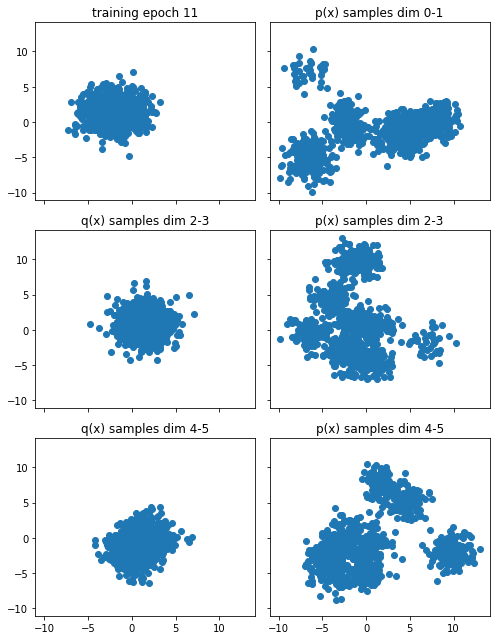

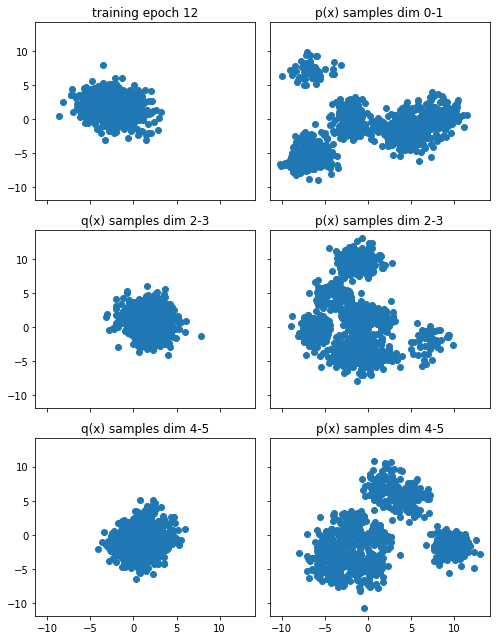

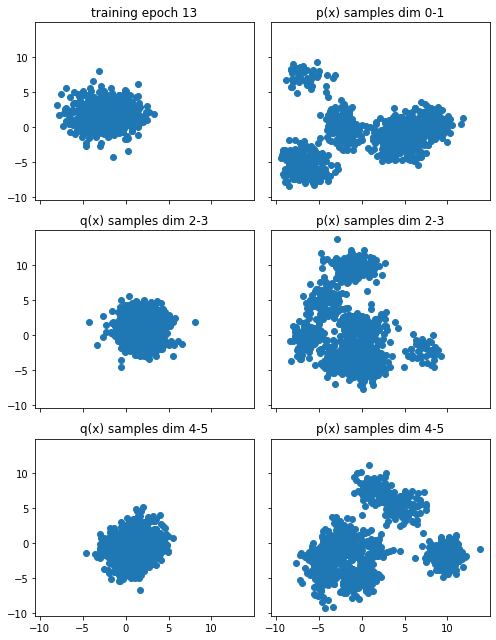

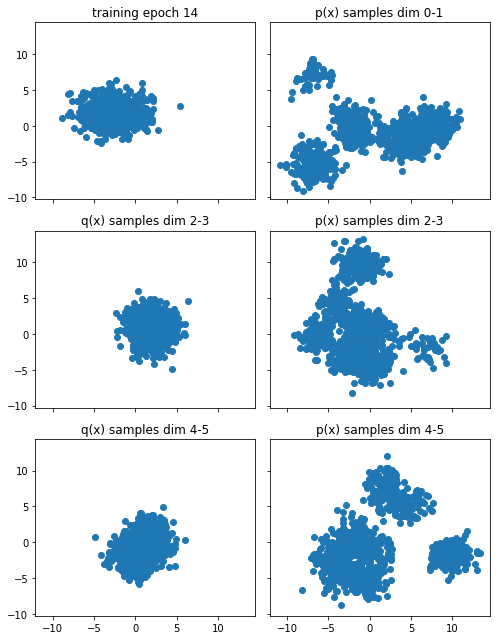

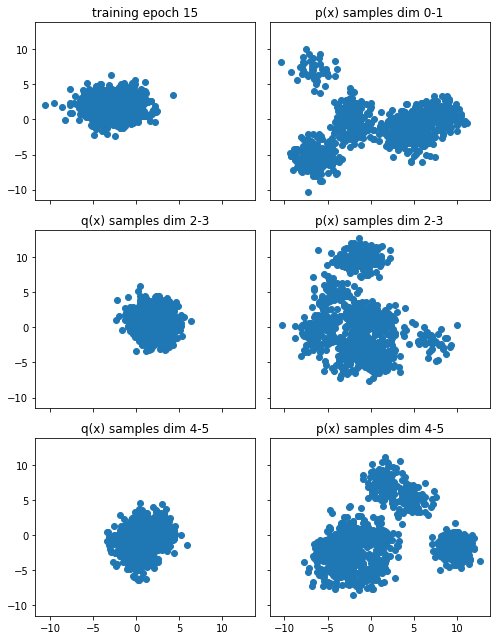

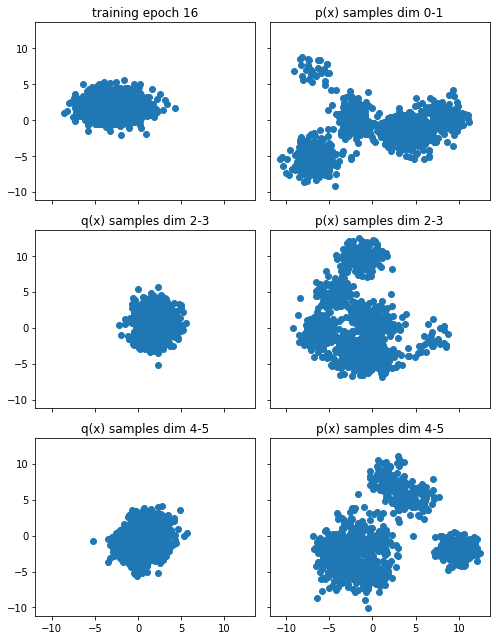

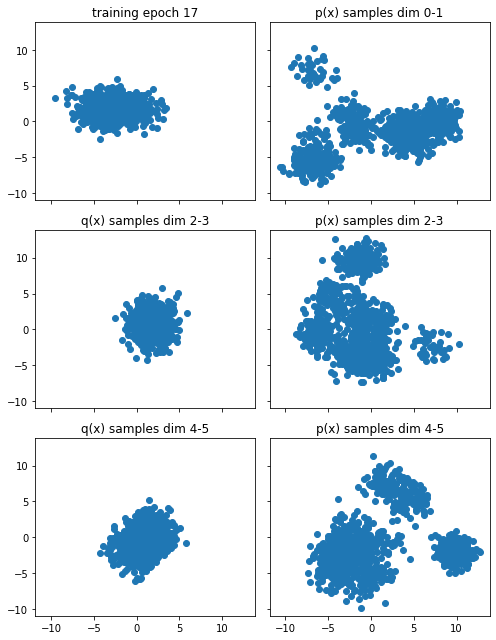

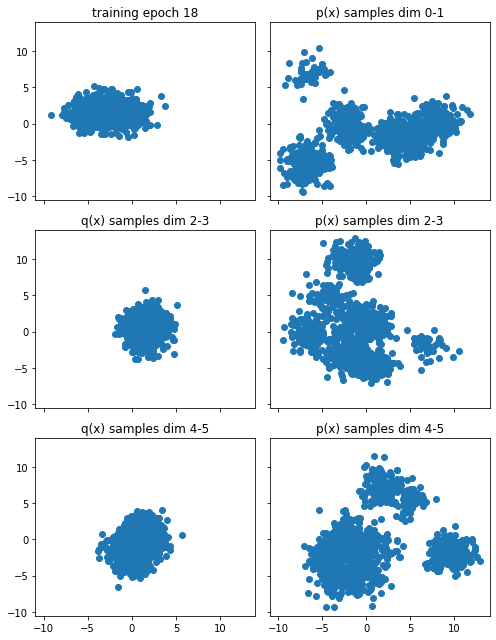

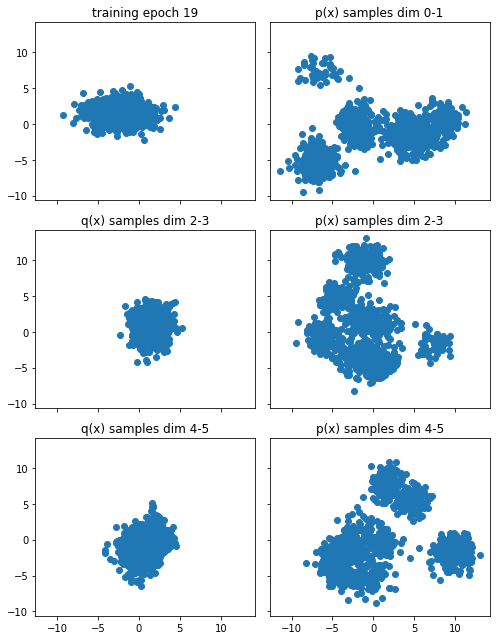

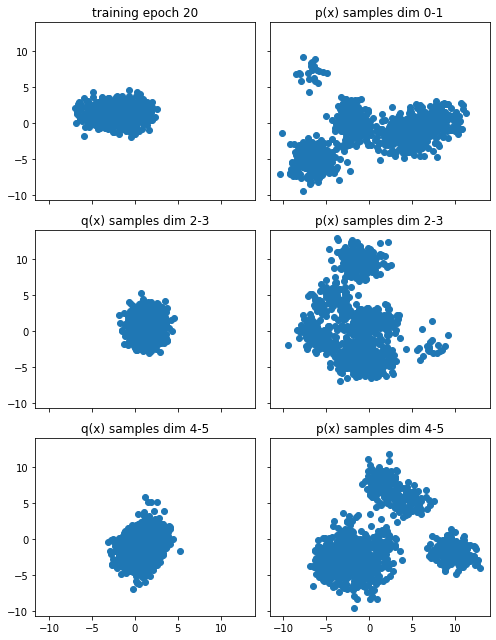

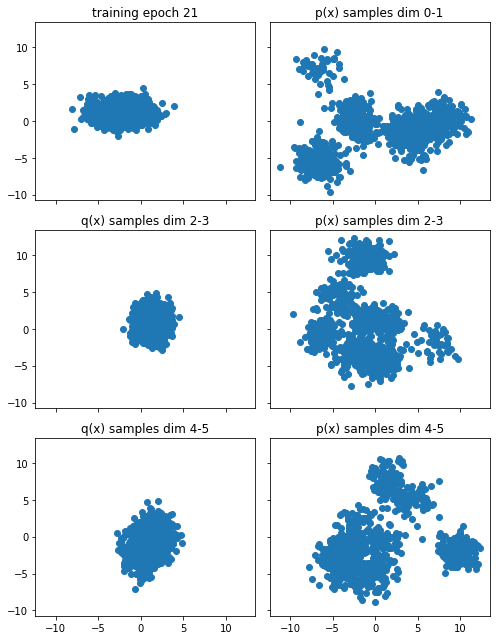

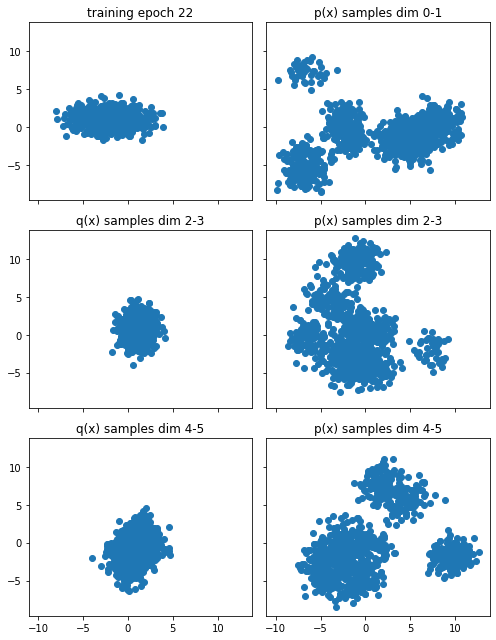

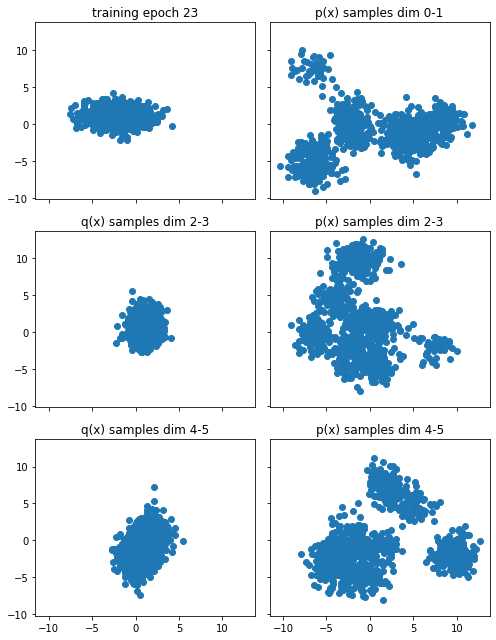

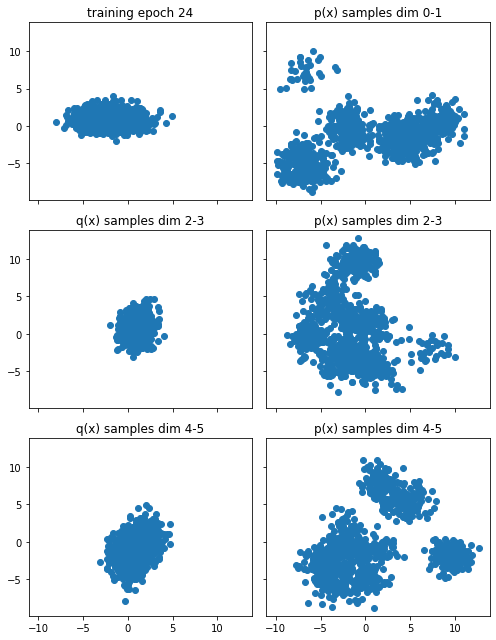

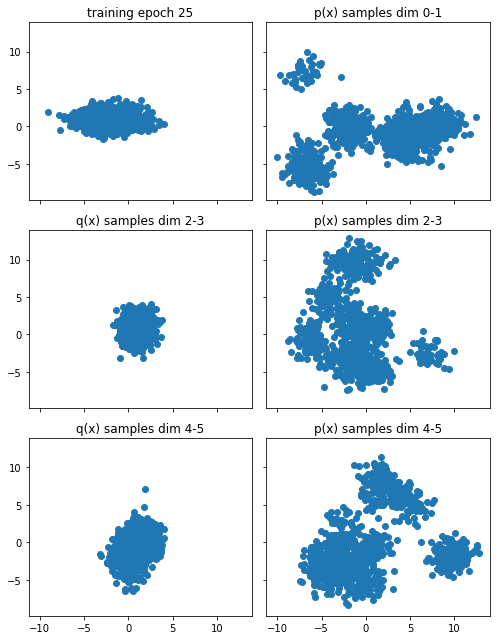

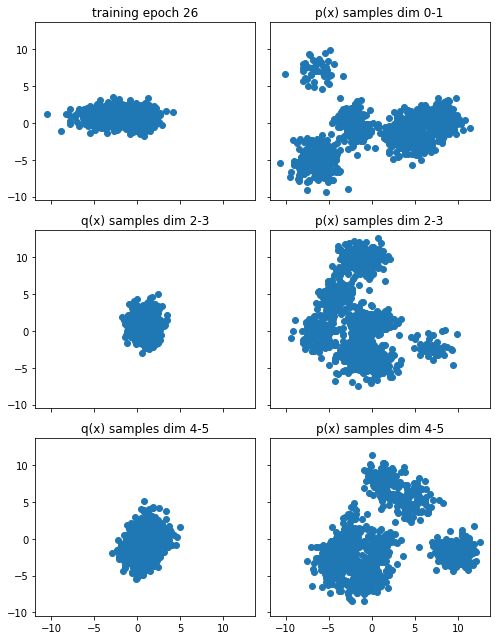

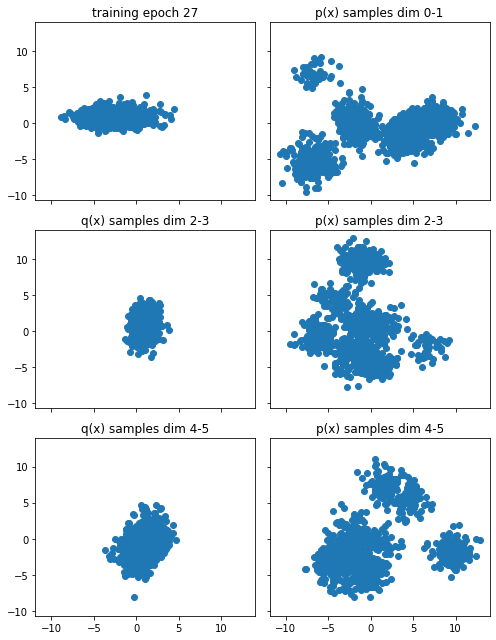

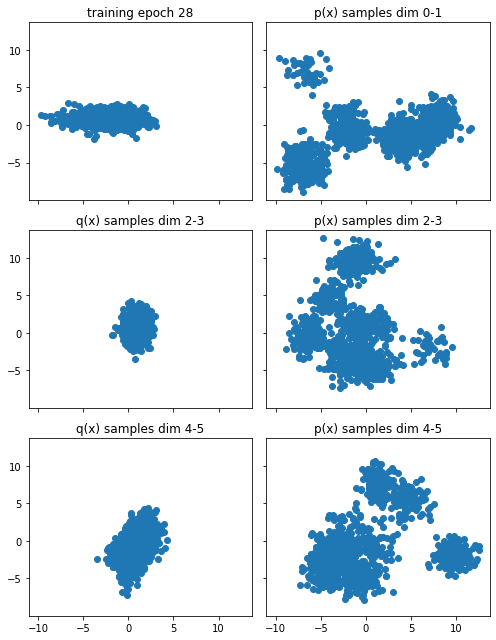

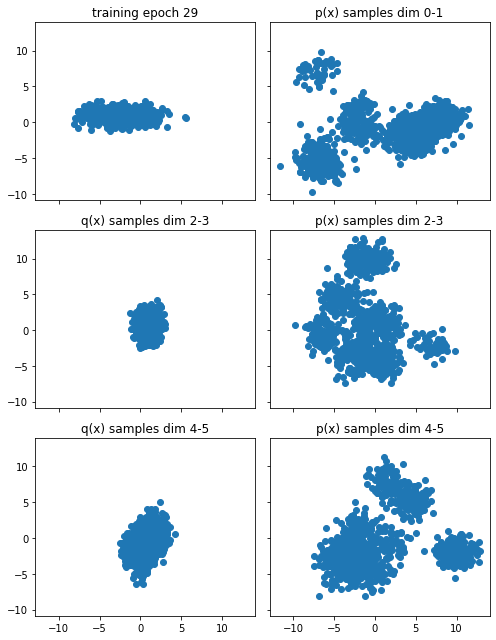

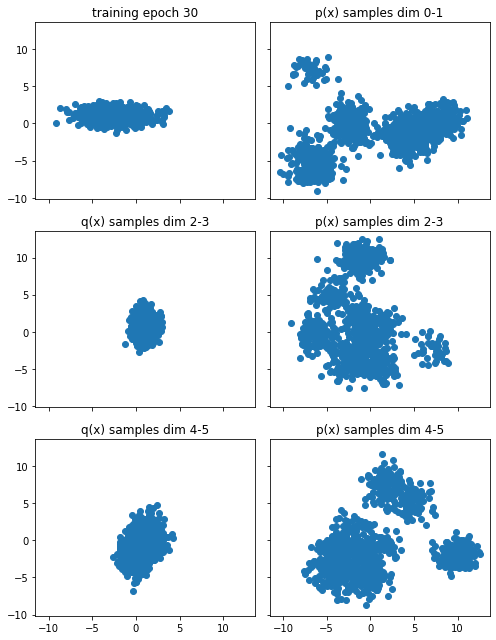

In [13]:
history = tester.train(50, batch_size=1000, intermediate_plots=True, n_plots=30)

In [ ]:
plot_history(history)

In [ ]:
plot_samples(tester)

In [ ]:
history = tester.train(500, batch_size=1000, intermediate_plots=True, n_plots=30)